<a href="https://colab.research.google.com/github/alibehroozi43/Prediction-traffic-flow/blob/main/Prediction%20of%20daily%20demand%20with%20LSTM%20neural%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [265]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from datetime import datetime, timedelta , date ,time
from sklearn.preprocessing import MinMaxScaler
import requests, zipfile, io
import matplotlib.pyplot as plt

In [276]:
#The transaction files were imported and joined together
df=pd.DataFrame()
url = ["https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q1.zip", 'https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q2_1.zip','https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q2_2.zip','https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q3_1.zip', 'https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q3_2_1.zip', 'https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q3_2_2.zip', 'https://github.com/alibehroozi43/Prediction-traffic-flow/raw/main/Divvy_Trips_2019_Q4.zip']
filename = ["Divvy_Trips_2019_Q1/Divvy_Trips_2019_Q1.csv",'Divvy_Trips_2019_Q2_1.csv', 'Divvy_Trips_2019_Q2_2.csv','Divvy_Trips_2019_Q3_1.csv', 'Divvy_Trips_2019_Q3_2_1.csv', 'Divvy_Trips_2019_Q3_2_2.csv','Divvy_Trips_2019_Q4/Divvy_Trips_2019_Q4.csv']
for i in range(len(url)):
  r = requests.get(url[i])
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()

  df_i = pd.read_csv(filename[i], sep=',')
  df=pd.concat([df, df_i], ignore_index=True)
df.head()


,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,21742443,2019-01-01 00:04:37,2019-01-01 00:11:07,2167,390.0,199,Wabash Ave & Grand Ave,84,Milwaukee Ave & Grand Ave,Subscriber,Male,1989.0
1,21742444,2019-01-01 00:08:13,2019-01-01 00:15:34,4386,441.0,44,State St & Randolph St,624,Dearborn St & Van Buren St (*),Subscriber,Female,1990.0
2,21742445,2019-01-01 00:13:23,2019-01-01 00:27:12,1524,829.0,15,Racine Ave & 18th St,644,Western Ave & Fillmore St (*),Subscriber,Female,1994.0
3,21742446,2019-01-01 00:13:45,2019-01-01 00:43:28,252,"1,783.0",123,California Ave & Milwaukee Ave,176,Clark St & Elm St,Subscriber,Male,1993.0
4,21742447,2019-01-01 00:14:52,2019-01-01 00:20:56,1170,364.0,173,Mies van der Rohe Way & Chicago Ave,35,Streeter Dr & Grand Ave,Subscriber,Male,1994.0


In [277]:
#df.tripduration=pd.to_numeric(df.tripduration.str.replace(',', ''), 'coerce' ) #remove comma in duration time for sum,...
'''convert str to datetime'''
df['start_time'] = df['start_time'].map(lambda x: datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S")) #convert str to datetime
df['date'] = df['start_time'].map(lambda x: datetime.strptime(str(x.date()),"%Y-%m-%d")) #create column date from start_time
df['time'] = df['start_time'].map(lambda x: x.hour) #cearte column time hour from start_time
# Remove stations that lack information
fill = df[ (df['from_station_id']==1) | (df['from_station_id']==360) | (df['from_station_id']==361) | (df['from_station_id']==363) | (df['from_station_id']==669) | (df['to_station_id']==1) | (df['to_station_id']==360) | (df['to_station_id']==361) | (df['to_station_id']==363) | (df['to_station_id']==669)].index
df.drop(index=fill , axis=0 , inplace=True)



In [278]:
#Creating a trajectory dataframe for each hour
df=df.groupby(['date']).agg({'trip_id':'count'}).reset_index()

df.rename(columns={'trip_id' : 'demand'} , inplace=True)

In [279]:
df.head()


,date,demand
0,2019-01-01,1312
1,2019-01-02,4170
2,2019-01-03,5618
3,2019-01-04,6792
4,2019-01-05,6178


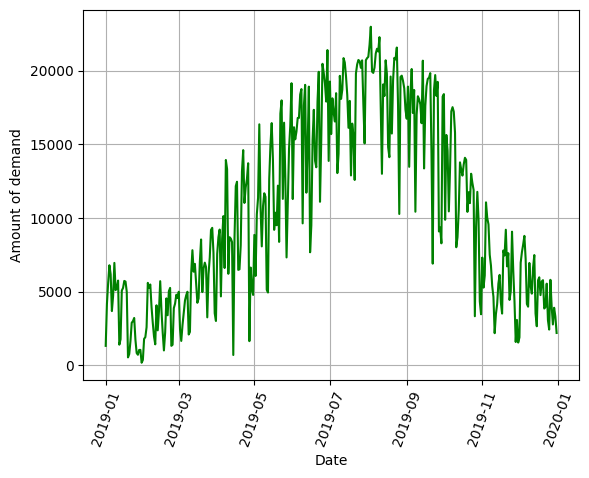

In [280]:
plt.plot_date(df['date'], df['demand'], 'g')
plt.xticks(rotation=70)
plt.grid(True)
plt.ylabel('Amount of demand')
plt.xlabel('Date')
plt.show()


In [282]:
scaler=MinMaxScaler(feature_range=(0, 1))
df=scaler.fit_transform(df['demand'].values.reshape(-1,1))

In [283]:
training_size=int(len(df)*0.7)
test_size=len(df)-training_size
train_data, test_data= df[0:training_size, :], df[training_size:len(df), :]

In [284]:
class SequenceDataset(Dataset):

  def __init__(self, df, seq_len=12):
    self.data = df
    self.seq_len=seq_len
  def __getitem__(self, idx):
    return torch.Tensor(self.data[idx:idx+self.seq_len]), torch.Tensor(self.data[idx+self.seq_len])

  def __len__(self):
    return len(self.data)

train_data=SequenceDataset(train_data)
test_data=SequenceDataset(test_data)

In [285]:
batch_size=70
train_dataloader=DataLoader(train_data, batch_size, drop_last=True)
test_dataloader=DataLoader(test_data, batch_size, drop_last=True)
device= "cuda" if torch.cuda.is_available() else "cpu"

In [287]:
class LSTMForcast(nn.Module):
  def __init__(self, input_dim, hidden_size, num_layers):
    super(LSTMForcast, self).__init__()
    self.num_layers=num_layers
    self.hidden_size=hidden_size
    self.input_size=input_dim
    self.lstm=nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc=nn.Linear(hidden_size,1)
    self.relu = nn.ReLU()

  def forward(self,x):
    # hidden state
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    # cell state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    # propagate input through LSTM
    out, _ = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
    out = out[:, -1, :] # reshaping the data for Dense layer next
    out = self.relu(out)
    out = self.fc(out) # first dense
    return out


In [288]:
input_dim=1
hidden_size=128
num_layers=2
model=LSTMForcast(input_dim, hidden_size, num_layers)

In [289]:
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=1e-2)

In [295]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    i=0
    for batch_index, batch in enumerate(train_dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        avg_loss_across_batches = running_loss / 100
        print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                avg_loss_across_batches))
        running_loss = 0.0
    print()

In [298]:
def validate_one_epoch():
    min_valid_loss = np.inf
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_dataloader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_dataloader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()
    return avg_loss_across_batches


In [297]:
num_epochs=1000
min_valid_loss = np.inf
for epoch in range(num_epochs):
    train_one_epoch()
    avg_loss_across_batches=validate_one_epoch()
    if min_valid_loss > avg_loss_across_batches:
      print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{avg_loss_across_batches:.6f}) \t Saving The Model')
      min_valid_loss = avg_loss_across_batches
      torch.save(model.state_dict(), 'saved_model.pth')


Streaming output truncated to the last 5000 lines.
Epoch: 376
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 377
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 378
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 379
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 380
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 381
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 0.031
***************************************************

Epoch: 382
Batch 1, Loss: 0.000
Batch 2, Loss: 0.000
Batch 3, Loss: 0.000

Val Loss: 

In [293]:
y_acuall=[]
y_predict=[]
model.load_state_dict(torch.load('/content/saved_model.pth'))
model.eval()
for i, item in enumerate(test_dataloader):
  x_test, y_test = item
  y_acuall.append(y_test.to('cpu').numpy())
  with torch.no_grad():
      predicted = model(x_test).to('cpu').numpy()
      y_predict.append(predicted)




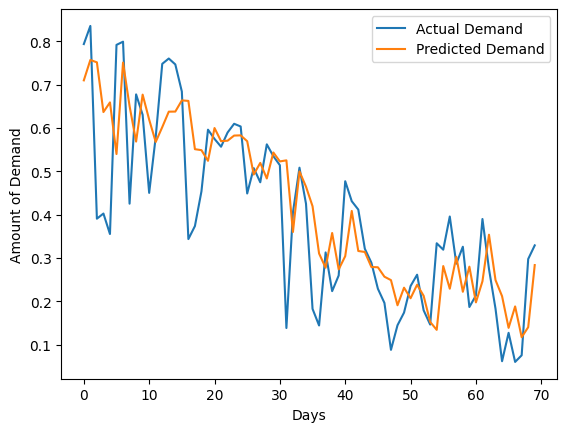

In [311]:
plt.plot(np.array(y_acuall).reshape(np.array(y_acuall).shape[1],np.array(y_acuall).shape[2]), label='Actual Demand')
plt.plot(np.array(y_predict).reshape(np.array(y_predict).shape[1],np.array(y_predict).shape[2]), label='Predicted Demand')
plt.ylabel('Amount of Demand')
plt.xlabel('Days')
plt.legend()
plt.show()